In [1]:
# Importo las bibliotecas a utilizar
import numpy
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import argparse

In [2]:
numpy.random.seed(7)

In [3]:
def create_dataset(dataset, look_back=1):
    """
    Se generan los instantes en tiempos t hacia atras
    para lograr predecir el instante t

    :param dataset: conjunto de datos completos
    :param look_back: cuantos instantes de tiempo t hacia atras seran utilizados
    :return: una matriz con los instantes de tiempo hacia atras y el instante presente
    """

    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [4]:
def remuestre(cantidad, dataframe):
    """
    Se hace un re muestreo en el dataframe disminuyendo la cantidad total
    de datos
    :param cantidad: cantidad de datos que seran promediados
    :param dataframe: el dataframe con el que se esta trabajando
    :return: dataframe: es el dataframe ya remuestrado
    """
    suma = 0
    contador = 0
    eliminar = []
    for i in range(len(dataframe)):
        contador += 1
        suma += dataframe.loc[i]
        if (contador == cantidad):
            dataframe.loc[i] = suma / cantidad
            contador = 0
            suma = 0
        else:
            eliminar.append(i)
    dataframe = dataframe.drop(dataframe.index[eliminar])
    return dataframe

In [5]:
def execute_lstm(unidades, date, look_back, neuronas, epocas, capas='6', training_split=0.67,optimizacion='adam', act='tanh'):    
    """
    función que reune la lógica de construcción, entrenamiento y test de la red recurrente LSTM
    """
    
    # normalizacion del dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    unidades = scaler.fit_transform(unidades)
    date = scaler.fit_transform(date)

    keras.callbacks.Callback()
    train_size = int(len(date) * training_split)
    test_size = len(date) - train_size
    date_train, date_test = date[0:train_size, :], date[train_size:len(date), :]
    unidades_train, unidades_test = unidades[0:train_size, :], unidades[train_size:len(unidades), :]
    print(len(date_train), len(unidades_test))

    date_train_lookback, date_train_tiempo_actual = create_dataset(date_train, look_back)  # date_train_lookback es la presion Entrenamiento
    date_test_lookback, date_test_tiempo_actual = create_dataset(date_test, look_back)  # date_test_lookback es la presion de test
    unidades_train_lookback, unidades_train_tiempo_actual = create_dataset(unidades_train, look_back)  # unidades_train_tiempo_actual autorregulacion de entrenamiento
    unidades_test_lookback, unidades_test_tiempo_actual = create_dataset(unidades_test, look_back)  # unidades_test_tiempo_actual autorregulacion de test

    #transformacion necesaria, para ser utilizados los datos para entrar a la red neuronal
    date_train_lookback = numpy.reshape(date_train_lookback, (date_train_lookback.shape[0], 1, date_train_lookback.shape[1]))
    date_test_lookback = numpy.reshape(date_test_lookback, (date_test_lookback.shape[0], 1, date_test_lookback.shape[1]))

    print("unidades_train_tiempo_actual", unidades_train_tiempo_actual)
    print("date_train_lookback", date_train_lookback)

    # create and fit the LSTM network
    csv_logger = keras.callbacks.CSVLogger('training.log', separator=',', append=False)
    model = Sequential()
    model.add(LSTM(neuronas, return_sequences = True, input_shape=(1, look_back)))
    for i in range(capas):
        model.add(LSTM(neuronas, return_sequences = True, activation=act))
    model.add(LSTM(neuronas))
    model.add(Dense(1, activation=act))
    model.compile(loss='mean_squared_error', optimizer=optimizacion)
    model.fit(date_train_lookback, unidades_train_tiempo_actual, epochs=epocas, batch_size=32, verbose=2, callbacks=[csv_logger])

    trainPredict = model.predict(date_train_lookback)
    testPredict = model.predict(date_test_lookback)

    corr = numpy.corrcoef(unidades_test_tiempo_actual, testPredict[:, 0])
    print('Test Score: %.2f CORRELACION' % (corr[1][0]))

    trainPredictPlot = numpy.empty_like(unidades)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

    testPredictPlot = numpy.empty_like(unidades)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict) + (look_back * 2) - 1 :len(unidades) - 1, :] = testPredict

    plt.figure(figsize=(25, 5))
    plt.plot(unidades)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.title("LSTM con %i neuronas, correlacion: %.2f" % (neuronas, corr[1][0] * 100))
    plt.ylabel("Unidades de Carne Vendidas")
    plt.xlabel("Tiempo")
    plt.show()

    registro = pandas.read_csv('training.log', sep=",")

    plt.figure(figsize=(25, 5))
    plt.plot(registro["epoch"].values, registro["loss"].values)
    plt.title("Error LSTM con %i neuronas, correlacion: %.2f" % (neuronas, corr[1][0] * 100))
    plt.ylabel("Error")
    plt.xlabel("Epocas")
    plt.show()
    
    return model, trainPredict, testPredict, scaler, date_train_lookback, unidades_train_tiempo_actual

In [6]:
# TRATAMIENTO DE DATOS
data = pandas.read_csv('./data/training_series.csv')

In [7]:
unidades = pandas.DataFrame(data['Close'])
unidades = unidades.values
unidades = unidades.astype('float32')

In [8]:
date = pandas.concat([data["Year"], data["Month"], data["Date"]],axis=1)
date = date.values
date = date.astype('float32')

872 375
unidades_train_tiempo_actual [0.04519892 0.04437858 0.04597068 0.05171704 0.0506826  0.05108267
 0.05250913 0.05348301 0.05101389 0.06407452 0.05840093 0.05888593
 0.05572987 0.05293339 0.05074722 0.05151105 0.05463475 0.05498624
 0.05174536 0.05975062 0.05818266 0.05691791 0.05498624 0.04308546
 0.04487562 0.04386938 0.0430693  0.04210353 0.04896516 0.04999959
 0.05280012 0.05064213 0.04907429 0.04960763 0.04669404 0.04852873
 0.0477407  0.04839534 0.0470295  0.04345316 0.03699559 0.04510194
 0.04234594 0.04072142 0.04786199 0.0449726  0.05526102 0.06110442
 0.06063563 0.06116903 0.05932224 0.06099129 0.06213886 0.06091034
 0.06147212 0.06542021 0.06545651 0.06446242 0.06555754 0.06346029
 0.06202972 0.06664467 0.06597781 0.04834282 0.05185443 0.05832416
 0.0632906  0.0650686  0.06748104 0.07179695 0.07210004 0.07092404
 0.07047552 0.07785445 0.0814954  0.08029526 0.07755947 0.079099
 0.07936174 0.07854545 0.07758361 0.08201265 0.08103067 0.07882428
 0.07910305 0.08731043 0.08

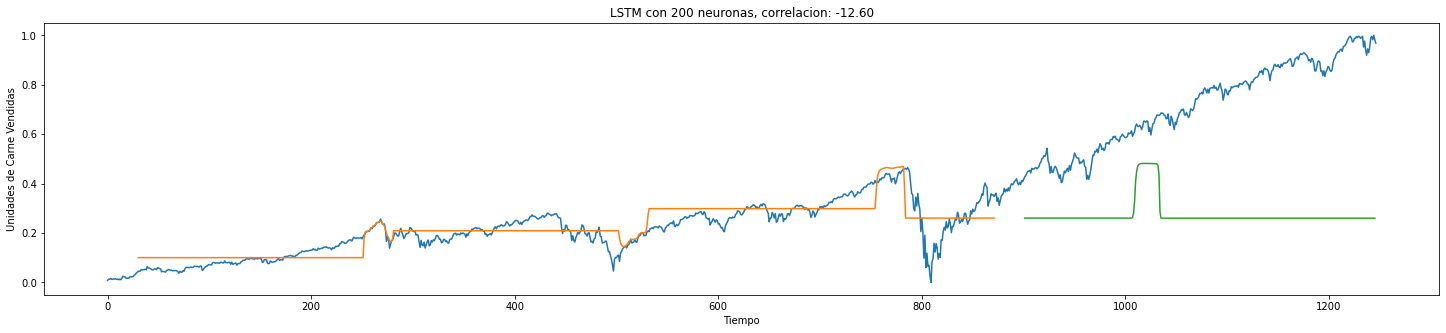

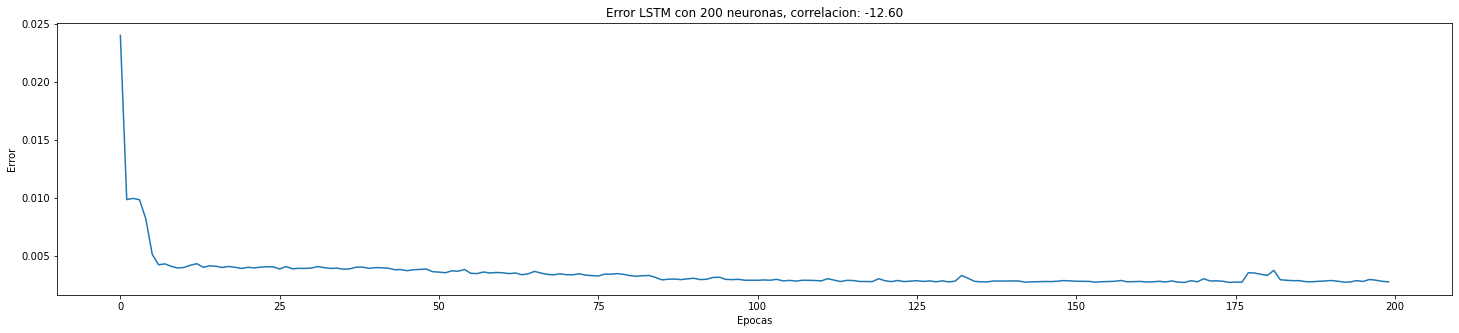

In [12]:
## EJECUCIÓN DE LA FUNCIÓN DE CONSTRUCCIÓN, ENTRENAMIENTO Y TEST DE LA RED
model1, trainPredict1, testPredict1, scaler1, x, y = execute_lstm(
    unidades,
    date,
    look_back=30,
    neuronas=200,
    epocas=200,
    capas=6,
    training_split=0.7,
    optimizacion='adam',
    act='tanh')
#

In [19]:
x

array([[[0.  , 0.  , 0.  , ..., 0.25, 0.25, 0.25]],

       [[0.  , 0.  , 0.  , ..., 0.25, 0.25, 0.25]],

       [[0.  , 0.  , 0.  , ..., 0.25, 0.25, 0.25]],

       ...,

       [[0.5 , 0.5 , 0.5 , ..., 0.75, 0.75, 0.75]],

       [[0.5 , 0.5 , 0.5 , ..., 0.75, 0.75, 0.75]],

       [[0.5 , 0.5 , 0.5 , ..., 0.75, 0.75, 0.75]]], dtype=float32)

In [ ]:
y

In [40]:
# DATOS DEL MES DE NOVIEMBRE A PREDECIR
predict_data1 = pandas.read_csv('./data/test_series.csv')
scaler = MinMaxScaler(feature_range=(0, 1))
unidades1 = scaler.fit_transform(unidades)

In [41]:
predict_data1 = predict_data1.values
predict_data1 = predict_data1.astype('float32')

In [42]:
#se define lookback igual al usado en modelo neuronal
look_back1 = 365
predict_data_lookback1, predict_data_tiempo_actual1  = create_dataset(predict_data1, look_back1)

In [43]:
predict_data_lookback1 = numpy.reshape(predict_data_lookback1, (predict_data_lookback1.shape[0], 1, predict_data_lookback1.shape[1]))
#Predicción
predict_model1 = model1.predict(predict_data_lookback1)

IndexError: tuple index out of range

In [106]:
trainPredictPlot = numpy.empty_like(unidades)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back1:len(trainPredict1) + look_back1, :] = trainPredict1

In [103]:
testPredictPlot = numpy.empty_like(unidades)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict1) + (look_back1 * 2) - 1 :len(unidades) - 1, :] = testPredict1

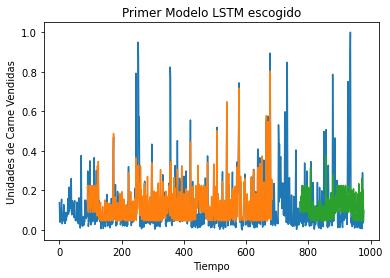

In [104]:
plt.plot(unidades1)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("Primer Modelo LSTM escogido")
plt.ylabel("Unidades de Carne Vendidas")
plt.xlabel("Tiempo")
plt.show()